
# 🏦 Loan Approval Prediction — End‑to‑End 

This notebook is a complete starter for **Loan Approval Prediction** on a Kaggle-style dataset.  
It covers:
- Data loading & quick checks
- **Preprocessing**: missing values, categorical encoding, train/test split
- **Imbalanced data** handling: `class_weight`, **SMOTE**
- Models: **Logistic Regression** vs **Decision Tree**
- Metrics: **Precision, Recall, F1-score, ROC-AUC**, confusion matrix
- **Threshold tuning** for Logistic Regression using Precision‑Recall curve




## 1) Setup

In [3]:

import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Sklearn core
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Imbalanced handling
from sklearn.utils.class_weight import compute_class_weight
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
!pip install imbalanced-learn


## 2) Load Data

In [4]:

DATA_PATH = "LoanApprovalPrediction.csv" 
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (598, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## 3) Quick Checks

In [5]:

display(df.isna().mean().sort_values(ascending=False).to_frame('missing_ratio').head(15))
display(df.describe(include='all').transpose().head(20))


,missing_ratio
Credit_History,0.081940
LoanAmount,0.035117
Loan_Amount_Term,0.023411
Dependents,0.020067
Loan_ID,0.000000
Gender,0.000000
Married,0.000000
Education,0.000000
Self_Employed,0.000000
ApplicantIncome,0.000000


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Loan_ID,598,598,LP001002,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,598,2,Male,487,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Married,598,2,Yes,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,586.0,NaN,NaN,NaN,0.755973,1.007751,0.0,0.0,0.0,1.75,3.0
Education,598,2,Graduate,465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Self_Employed,598,2,No,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ApplicantIncome,598.0,NaN,NaN,NaN,5292.252508,5807.265364,150.0,2877.5,3806.0,5746.0,81000.0
CoapplicantIncome,598.0,NaN,NaN,NaN,1631.499866,2953.315785,0.0,0.0,1211.5,2324.0,41667.0
LoanAmount,577.0,NaN,NaN,NaN,144.968804,82.704182,9.0,100.0,127.0,167.0,650.0
Loan_Amount_Term,584.0,NaN,NaN,NaN,341.917808,65.205994,12.0,360.0,360.0,360.0,480.0


## 4) Define Target and Feature Types

In [6]:

TARGET = "Loan_Status" 
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' and c != TARGET]
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

y_raw = df[TARGET]
# Basic mapping examples (customize to your labels)
if set(y_raw.unique()) <= set(['Y', 'N']):
    y = (y_raw == 'Y').astype(int)
elif set(y_raw.unique()) <= set(['Approved', 'Rejected']):
    y = (y_raw == 'Approved').astype(int)
else:
    # If already 0/1 or similar
    y = pd.to_numeric(y_raw, errors='coerce')
    if not set(y.dropna().unique()) <= set([0,1]):
        raise ValueError("Please map your target to {0,1} in the cell above.")

X = df.drop(columns=[TARGET])


Categorical: ['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
Numeric: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


## 5) Preprocessing Pipelines

In [7]:

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
])


## 6) Train / Test Split

In [8]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True).rename({0:'Not Approved', 1:'Approved'}))


Train size: (478, 12) Test size: (120, 12)
Class balance (train):
Loan_Status
Approved        0.688285
Not Approved    0.311715
Name: proportion, dtype: float64


## 7) Baselines (Class Weights) — Logistic Regression vs Decision Tree

In [9]:

# Logistic Regression with class_weight='balanced'
logreg_clw = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])

# Decision Tree with class_weight-like handling via class_weight (works for some criteria)
# Note: sklearn's DecisionTreeClassifier supports class_weight from 1.4+ for 'gini'/'entropy'.
# If not available in your version, you can sample weights via fit(sample_weight=...).
dt_clw = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
])

models = {
    "LogReg (class_weight)": logreg_clw,
    "DecisionTree (class_weight)": dt_clw
}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = getattr(pipe.named_steps["clf"], "predict_proba", lambda X: None)(pipe.named_steps["prep"].transform(X_test))
    auc = roc_auc_score(y_test, y_proba[:,1]) if y_proba is not None else np.nan
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC-AUC:", auc)



=== LogReg (class_weight) ===
              precision    recall  f1-score   support

           0     0.8261    0.5000    0.6230        38
           1     0.8041    0.9512    0.8715        82

    accuracy                         0.8083       120
   macro avg     0.8151    0.7256    0.7472       120
weighted avg     0.8111    0.8083    0.7928       120

ROC-AUC: 0.8382541720154043

=== DecisionTree (class_weight) ===
              precision    recall  f1-score   support

           0     0.6562    0.5526    0.6000        38
           1     0.8068    0.8659    0.8353        82

    accuracy                         0.7667       120
   macro avg     0.7315    0.7092    0.7176       120
weighted avg     0.7591    0.7667    0.7608       120

ROC-AUC: 0.7092426187419768


## 8) Handling Imbalance with SMOTE

In [10]:

# SMOTE applies in feature space => must come AFTER preprocessing
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

logreg_smote = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", smote),
    ("clf", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

dt_smote = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", smote),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

smote_models = {
    "LogReg + SMOTE": logreg_smote,
    "DecisionTree + SMOTE": dt_smote
}

for name, pipe in smote_models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = getattr(pipe.named_steps["clf"], "predict_proba", lambda X: None)(pipe.named_steps["prep"].transform(X_test))
    auc = roc_auc_score(y_test, y_proba[:,1]) if y_proba is not None else np.nan
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC-AUC:", auc)



=== LogReg + SMOTE ===
              precision    recall  f1-score   support

           0     0.8571    0.4737    0.6102        38
           1     0.7980    0.9634    0.8729        82

    accuracy                         0.8083       120
   macro avg     0.8276    0.7185    0.7415       120
weighted avg     0.8167    0.8083    0.7897       120

ROC-AUC: 0.8430680359435173

=== DecisionTree + SMOTE ===
              precision    recall  f1-score   support

           0     0.8947    0.4474    0.5965        38
           1     0.7921    0.9756    0.8743        82

    accuracy                         0.8083       120
   macro avg     0.8434    0.7115    0.7354       120
weighted avg     0.8246    0.8083    0.7863       120

ROC-AUC: 0.7114890885750962


## 9) Confusion Matrices

<Figure size 640x480 with 0 Axes>

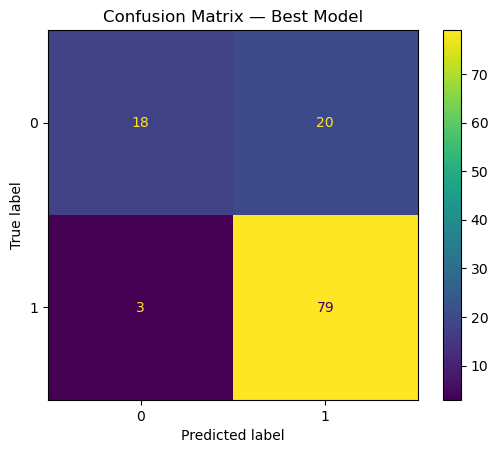

In [11]:

plt.figure()
best_model = logreg_smote  # change this to view another
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title("Confusion Matrix — Best Model")
plt.show()


## 10) ROC & Precision‑Recall Curves (Logistic Regression Example)

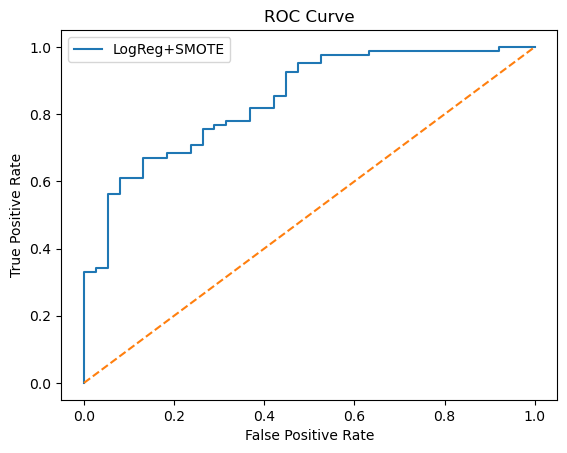

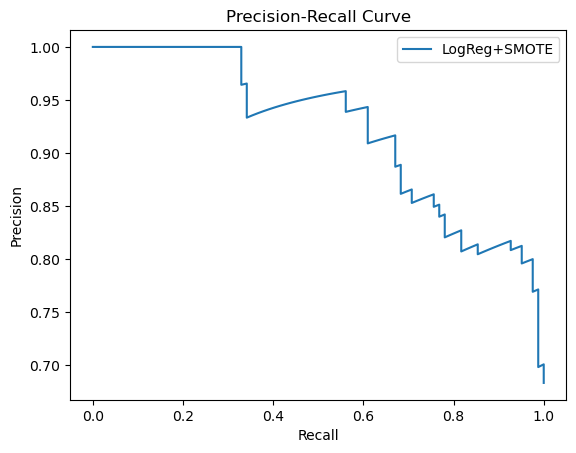

In [12]:

# Fit a fresh logistic regression with SMOTE for curves
logreg_smote.fit(X_train, y_train)
X_test_t = logreg_smote.named_steps["prep"].transform(X_test)
# Note: For ImbPipeline, need to pass through the pipeline to get proba
y_proba = logreg_smote.named_steps["clf"].predict_proba(X_test_t)[:,1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label="LogReg+SMOTE")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall curve
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label="LogReg+SMOTE")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## 11) Threshold Tuning (Optimize F1 or Precision/Recall Preference)

Best by F1:
 thr          0.460000
precision    0.800000
recall       0.975610
f1           0.879121
Name: 18, dtype: float64


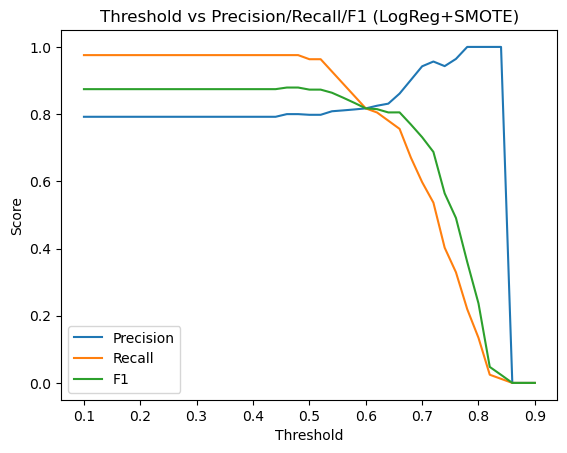

In [13]:

def evaluate_threshold(y_true, y_scores, thr):
    y_hat = (y_scores >= thr).astype(int)
    return {
        "thr": thr,
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0)
    }

# Sweep thresholds
stats = [evaluate_threshold(y_test, y_proba, t) for t in np.linspace(0.1, 0.9, 41)]
df_thr = pd.DataFrame(stats)
best_row = df_thr.loc[df_thr["f1"].idxmax()]
print("Best by F1:\n", best_row)

plt.figure()
plt.plot(df_thr["thr"], df_thr["precision"], label="Precision")
plt.plot(df_thr["thr"], df_thr["recall"], label="Recall")
plt.plot(df_thr["thr"], df_thr["f1"], label="F1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall/F1 (LogReg+SMOTE)")
plt.legend()
plt.show()


## 12) Cross‑Validation (Optional)

In [14]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"precision": "precision", "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}
cv_res = cross_validate(logreg_smote, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
pd.DataFrame(cv_res).agg(['mean','std']).transpose()


,mean,std
fit_time,0.140017,0.010343
score_time,0.076993,0.009179
test_precision,0.797573,0.031035
test_recall,0.943961,0.042825
test_f1,0.864009,0.026199
test_roc_auc,0.752771,0.041508


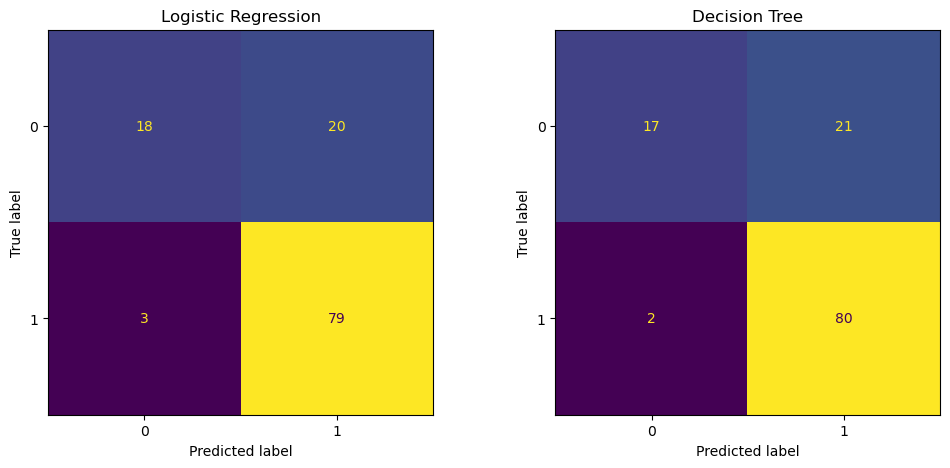

In [20]:

# ================================
# 2. Confusion Matrix Side by Side
# ================================
fig, ax = plt.subplots(1, 2, figsize=(12,5))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_log)).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt)).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Decision Tree")

plt.show()


## 13) Tips & Notes
- Tune **class weights** (`class_weight={0: w0, 1: w1}`) to bias toward positive approvals or rejections.
- For Decision Trees, consider `max_depth`, `min_samples_split`, `min_samples_leaf` to prevent overfitting.
- Try more models (RandomForest, XGBoost/LightGBM, SVM) for potentially better performance.
- When business impact prefers **reducing false approvals**, push for **higher precision** via threshold tuning.
- When inclusivity is key, aim for **higher recall** (catch more true approvals), accepting more false positives.
